In [ ]:
# 為colab環境建立虛擬銀幕
!apt-get install xvfb
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 783 kB in 0s (8,933 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.7_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.7) ...
Setting up xvfb (2:1.19.6-1ubuntu4.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import os

import gym
import time
import keras
import threading
import multiprocessing

import numpy as np
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import matplotlib.pyplot as plt

from PIL import Image
from queue import Queue
from keras import layers
from IPython import display
from pyvirtualdisplay import Display

2.3.0
Num GPUs Available:  1


In [ ]:
# 虛擬銀幕
vir_display = Display(visible=0, size=(1400, 900))
vir_display.start()

In [ ]:
class RandomAgent:
  def __init__(self, env_name, max_eps):
    self.env = gym.make(env_name)
    self.max_episodes = max_eps
    self.global_moving_average_reward = 0
    self.res_queue = Queue()

  def run(self):
    reward_avg = 0
    for episode in range(self.max_episodes):
      done = False
      self.env.reset()
      reward_sum = 0.0
      steps = 0
      while not done:
        # 隨機生成玩家指令
        _, reward, done, _ = self.env.step(self.env.action_space.sample())
        steps += 1
        reward_sum += reward
      # 計算累積局數內的平均得分
      self.global_moving_average_reward = record(episode, 
                                                 reward_sum, 
                                                 0,
                                                 self.global_moving_average_reward,
                                                 self.res_queue, 0, steps)

      reward_avg += reward_sum
    final_avg = reward_avg / float(self.max_episodes)
    print("Average score across {} episodes: {}".format(self.max_episodes, final_avg))
    return final_avg

def record(episode,
           episode_reward,
           worker_idx,
           global_ep_reward,
           result_queue,
           total_loss,
           num_steps):
  if global_ep_reward == 0:
    global_ep_reward = episode_reward
  else:
    global_ep_reward = global_ep_reward * 0.99 + episode_reward * 0.01
  print(
      f"Episode: {episode} | "
      f"Moving Average Reward: {int(global_ep_reward)} | "
      f"Episode Reward: {int(episode_reward)} | "
      f"Loss: {int(total_loss / float(num_steps) * 1000) / 1000} | "
      f"Steps: {num_steps} | "
      f"Worker: {worker_idx}"
  )
  result_queue.put(global_ep_reward)
  return global_ep_reward

class ActorCriticModel(keras.Model):
  def __init__(self, state_size, action_size):
    super(ActorCriticModel, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.dense1 = layers.Dense(100, activation='relu')
    self.policy_logits = layers.Dense(action_size)
    self.dense2 = layers.Dense(100, activation='relu')
    self.values = layers.Dense(1)

  def call(self, inputs):
    # Forward pass
    x = self.dense1(inputs)
    logits = self.policy_logits(x)
    v1 = self.dense2(inputs)
    values = self.values(v1)
    return logits, values

class MasterAgent():
  def __init__(self):
    self.game_name = 'CartPole-v0'
    self.save_dir = save_dir
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)

    env = gym.make(self.game_name)
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.n
    self.opt = keras.optimizers.Adam(lr)
    print(self.state_size, self.action_size)

    self.global_model = ActorCriticModel(self.state_size, self.action_size)  # global network
    self.global_model(np.random.random((1, self.state_size)).astype('float32'))

  def train(self):
    res_queue = Queue()

    workers = [Worker(self.state_size,
                      self.action_size,
                      self.global_model,
                      self.opt, res_queue,
                      i, game_name=self.game_name,
                      save_dir=self.save_dir) for i in range(multiprocessing.cpu_count())]

    for i, worker in enumerate(workers):
      print("Starting worker {}".format(i))
      worker.start()

    moving_average_rewards = []  # 用於紀錄個時間點每局平均得分
    while True:
      reward = res_queue.get()
      if reward is not None:
        moving_average_rewards.append(reward)
      else:
        break
    [w.join() for w in workers]

    plt.plot(moving_average_rewards)
    plt.ylabel('Moving average ep reward')
    plt.xlabel('Step')
    plt.savefig(os.path.join(self.save_dir,
                             '{} Moving Average.png'.format(self.game_name)))
    plt.show()

  def play(self):
    env = gym.make(self.game_name).unwrapped
    state = env.reset()
    model = self.global_model
    model_path = os.path.join(self.save_dir, 'model_{}.h5'.format(self.game_name))
    print('Loading model from: {}'.format(model_path))
    model.load_weights(model_path)
    done = False
    step_counter = 0
    reward_sum = 0

    try:
      while not done:
        policy, value = model(state[None, :].astype('float32'))
        policy = tf.nn.softmax(policy)
        action = np.argmax(policy)
        state, reward, done, _ = env.step(action)
        reward_sum += reward

        display.clear_output(wait=True)
        rgb_array = env.render(mode='rgb_array')
        img = Image.fromarray(rgb_array)
        display.display(img)
        print("                    Step:{}. Reward: {}, action: {}".format(step_counter, reward_sum, action))
        time.sleep(0.015)

        step_counter += 1
    except KeyboardInterrupt:
      print("Received Keyboard Interrupt. Shutting down.")
    finally:
      env.close()

class Memory:
  def __init__(self):
    self.states = []
    self.actions = []
    self.rewards = []

  def store(self, state, action, reward):
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)

  def clear(self):
    self.states = []
    self.actions = []
    self.rewards = []

class Worker(threading.Thread):
  # 初始化當前局次
  global_episode = 0
  # 初始化當前每局平均得分
  global_moving_average_reward = 0
  best_score = 0
  save_lock = threading.Lock()

  def __init__(self,
               state_size,
               action_size,
               global_model,
               opt,
               result_queue,
               idx,
               game_name='CartPole-v0',
               save_dir='tmp'):
    super(Worker, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.result_queue = result_queue
    self.global_model = global_model
    self.opt = opt
    self.local_model = ActorCriticModel(self.state_size, self.action_size)
    self.worker_idx = idx
    self.game_name = game_name
    self.env = gym.make(self.game_name).unwrapped
    self.save_dir = save_dir
    self.ep_loss = 0.0

  def run(self):
    total_step = 1
    mem = Memory()
    while Worker.global_episode < max_eps:
      current_state = self.env.reset()
      mem.clear()
      ep_reward = 0.
      ep_steps = 0
      self.ep_loss = 0

      time_count = 0
      done = False
      while not done:
        logits, _ = self.local_model(current_state[None, :].astype('float32'))
        probs = tf.nn.softmax(logits)

        action = np.random.choice(self.action_size, p=probs.numpy()[0])
        new_state, reward, done, _ = self.env.step(action)
        if done:
          reward = -1
        ep_reward += reward
        mem.store(current_state, action, reward)

        if time_count == update_freq or done:
          # 計算梯度修正以更新模型參數
          with tf.GradientTape() as tape:
            total_loss = self.compute_loss(done,
                                           new_state,
                                           mem,
                                           gamma)
          self.ep_loss += total_loss
          # 計算梯度修正
          grads = tape.gradient(total_loss, self.local_model.trainable_weights)
          # 為模型套用梯度修正
          self.opt.apply_gradients(zip(grads,
                                       self.global_model.trainable_weights))
          # 更新新修正的模型參數
          self.local_model.set_weights(self.global_model.get_weights())

          mem.clear()
          time_count = 0

          if done:  # 當局遊戲結束，顯示得分
            Worker.global_moving_average_reward = \
              record(Worker.global_episode, ep_reward, self.worker_idx,
                     Worker.global_moving_average_reward, self.result_queue,
                     self.ep_loss, ep_steps)
            # 使用lock防止 race condition
            if ep_reward > Worker.best_score:
              with Worker.save_lock:
                print("Saving best model to {}, "
                      "episode score: {}".format(self.save_dir, ep_reward))
                self.global_model.save_weights(
                    os.path.join(self.save_dir,
                                 'model_{}.h5'.format(self.game_name))
                )
                Worker.best_score = ep_reward
            Worker.global_episode += 1
        ep_steps += 1

        time_count += 1
        current_state = new_state
        total_step += 1
    self.result_queue.put(None)

  def compute_loss(self,
                   done,
                   new_state,
                   memory,
                   gamma=0.99):
    if done:
      reward_sum = 0.  # 遊戲結束，積分歸零
    else:
      reward_sum = self.local_model(new_state[None, :].astype('float32'))[-1].numpy()[0]

    # Get discounted rewards
    discounted_rewards = []
    for reward in memory.rewards[::-1]:  # reverse buffer r
      reward_sum = reward + gamma * reward_sum
      discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()

    logits, values = self.local_model(np.vstack(memory.states).astype('float32'))
    # Get our advantages
    advantage = np.array(discounted_rewards)[:, None] - values
    # 得分損失
    value_loss = advantage ** 2

    # 策略損失
    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits(labels=policy, logits=logits)

    policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=memory.actions, logits=logits)

    policy_loss *= tf.stop_gradient(advantage)
    policy_loss -= 0.01 * entropy
    total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
    return total_loss

In [ ]:
# 首先嘗試隨機下達指令，每局得分大致落在20上下
game_name, max_eps = 'CartPole-v0', 4000
random_agent = RandomAgent(game_name, max_eps)
random_agent.run()

Episode: 0 | Moving Average Reward: 17 | Episode Reward: 17 | Loss: 0.0 | Steps: 17 | Worker: 0
Episode: 1 | Moving Average Reward: 17 | Episode Reward: 18 | Loss: 0.0 | Steps: 18 | Worker: 0
Episode: 2 | Moving Average Reward: 17 | Episode Reward: 44 | Loss: 0.0 | Steps: 44 | Worker: 0
Episode: 3 | Moving Average Reward: 17 | Episode Reward: 11 | Loss: 0.0 | Steps: 11 | Worker: 0
Episode: 4 | Moving Average Reward: 17 | Episode Reward: 19 | Loss: 0.0 | Steps: 19 | Worker: 0
Episode: 5 | Moving Average Reward: 17 | Episode Reward: 10 | Loss: 0.0 | Steps: 10 | Worker: 0
Episode: 6 | Moving Average Reward: 17 | Episode Reward: 12 | Loss: 0.0 | Steps: 12 | Worker: 0
Episode: 7 | Moving Average Reward: 17 | Episode Reward: 20 | Loss: 0.0 | Steps: 20 | Worker: 0
Episode: 8 | Moving Average Reward: 17 | Episode Reward: 20 | Loss: 0.0 | Steps: 20 | Worker: 0
Episode: 9 | Moving Average Reward: 17 | Episode Reward: 31 | Loss: 0.0 | Steps: 31 | Worker: 0
Episode: 10 | Moving Average Reward: 17 

22.42475

4 2
Starting worker 0
Starting worker 1
Episode: 0 | Moving Average Reward: 16 | Episode Reward: 16 | Loss: 2.444 | Steps: 17 | Worker: 1
Saving best model to tmp/, episode score: 16.0
Episode: 0 | Moving Average Reward: 15 | Episode Reward: 8 | Loss: 1.31 | Steps: 9 | Worker: 0
Saving best model to tmp/, episode score: 8.0
Episode: 2 | Moving Average Reward: 15 | Episode Reward: 15 | Loss: 2.322 | Steps: 16 | Worker: 0
Saving best model to tmp/, episode score: 15.0
Episode: 3 | Moving Average Reward: 15 | Episode Reward: 22 | Loss: 3.346 | Steps: 23 | Worker: 1
Saving best model to tmp/, episode score: 22.0
Episode: 4 | Moving Average Reward: 16 | Episode Reward: 23 | Loss: 3.222 | Steps: 24 | Worker: 0
Saving best model to tmp/, episode score: 23.0
Episode: 5 | Moving Average Reward: 16 | Episode Reward: 37 | Loss: 3.076 | Steps: 38 | Worker: 1
Saving best model to tmp/, episode score: 37.0
Episode: 5 | Moving Average Reward: 16 | Episode Reward: 18 | Loss: 2.685 | Steps: 19 | Worker

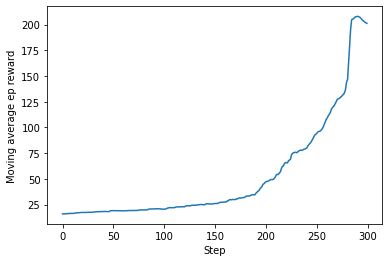

In [ ]:
# 嘗試多工訓練a3c模型
save_dir = 'tmp/'
update_freq = 20
gamma = 0.99
lr = 0.001
max_eps = 300

master = MasterAgent()
master.train()  

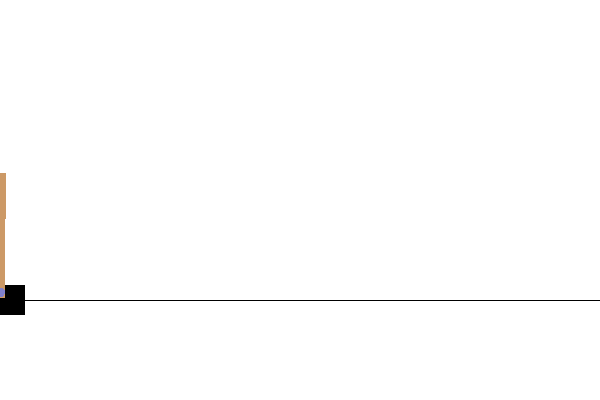

                    Step:4661. Reward: 4662.0, action: 1


In [ ]:
# 使用已訓練的a3c模型作為玩家遊玩
master = MasterAgent()
master.play()